In [1]:
# To ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Import the libraries to handle the np array and pandas dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import py files
import acquire, prepare, explore

import psutil
from tqdm.notebook import tqdm
import gc

### Acquire and Prepare the Train/Validate/Test Dataset

In [2]:
%%time

# Define the data types
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16", 
    "content_type_id": "boolean", 
    "task_container_id": "int16",
    "user_answer": "int8", 
    "answered_correctly": "int8", 
    "prior_question_elapsed_time": "float32"   
}

# Load train/validate/test
df_train = pd.read_csv("../Riiid-Project/sampled_trainset.csv", index_col=0, dtype=dtypes)
df_validate = pd.read_csv("../Riiid-Project/validate.csv", index_col=0, dtype=dtypes)
df_test = pd.read_csv("../Riiid-Project/test.csv", index_col=0, dtype=dtypes)

CPU times: user 45 s, sys: 4.12 s, total: 49.1 s
Wall time: 49.8 s


In [3]:
%%time

# Define the data types
dtypes = {
    "question_id": "int16", 
    "bundle_id": "int16",
    "correct_answer": "int8", 
    "part": "int8", 
    "tags": "object", 
    "tag_count": "int8"    
    }

# Load questions dataset
df_ques = pd.read_csv('questions_with_tag_counts.csv', index_col=0, dtype=dtypes)

CPU times: user 8.17 ms, sys: 5.25 ms, total: 13.4 ms
Wall time: 13.4 ms


In [4]:
# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20964878 entries, 0 to 13083813322
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   content_type_id                 boolean
 3   task_container_id               int16  
 4   user_answer                     int8   
 5   answered_correctly              int8   
 6   prior_question_elapsed_time     float32
 7   prior_question_had_explanation  object 
 8   lecture_id                      float64
 9   tag                             float64
 10  lecture_part                    float64
 11  type_of                         object 
 12  question_id                     float64
 13  bundle_id                       float64
 14  correct_answer                  float64
 15  question_part                   float64
 16  tags                            object 
dtypes: boolean(1), float32

In [5]:
%%time

# Drop columns that are not needed

cols = ['lecture_id', 'tag', 'lecture_part','type_of', 'question_id', 'bundle_id', 
        'correct_answer', 'question_part', 'tags', 'content_type_id', 'user_answer']

df_train.drop(columns=cols, inplace=True)
df_validate.drop(columns=cols, inplace=True)
df_test.drop(columns=cols, inplace=True)

CPU times: user 492 ms, sys: 449 ms, total: 941 ms
Wall time: 1.03 s


In [6]:
# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20964878 entries, 0 to 13083813322
Data columns (total 6 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  object 
dtypes: float32(1), int16(2), int32(1), int8(1), object(1)
memory usage: 579.8+ MB


In [7]:
# Print the information of df_ques
df_ques.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13523 entries, 0 to 13522
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
 5   tag_count       13523 non-null  int8  
dtypes: int16(2), int8(3), object(1)
memory usage: 303.7+ KB


In [8]:
%%time
# Drop lecture rows

mask = (df_train.answered_correctly != -1)
df_train = df_train[mask]

mask = (df_validate.answered_correctly != -1)
df_validate = df_validate[mask]

mask = (df_test.answered_correctly != -1)
df_test = df_test[mask]

CPU times: user 1.05 s, sys: 480 ms, total: 1.53 s
Wall time: 1.74 s


In [9]:
%%time

# Merge df_train and df_ques
df_train = df_train.merge(df_ques, how='left', left_on='content_id', right_on='question_id')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  object 
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
dtypes: float32(1), int16(4), int32(1), int8(4), object(2)
memory usage: 862.5+ MB
CPU times: user 3.05 s, sys: 982 ms, total: 4.04 s
Wall time: 4.05 s


In [12]:
# Check the nulls in df_train
df_train.isnull().sum(axis=0)

user_id                               0
content_id                            0
task_container_id                     0
answered_correctly                    0
prior_question_elapsed_time       99720
prior_question_had_explanation    99720
question_id                           0
bundle_id                             0
correct_answer                        0
part                                  0
tags                                  1
tag_count                             0
dtype: int64

In [61]:
%%time

# Merge df_train and df_ques
df_validate = df_validate.merge(df_ques, how='left', left_on='content_id', right_on='question_id')
df_test = df_test.merge(df_ques, how='left', left_on='content_id', right_on='question_id')

CPU times: user 759 ms, sys: 280 ms, total: 1.04 s
Wall time: 1.08 s


In [13]:
# Check the nulls in df_validate
df_validate.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

In [14]:
# Check the nulls in df_test
df_test.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

In [15]:
%%time

# Fill the missing value in col `prior_question_elapsed_time` with 0
df_train.prior_question_elapsed_time.fillna(0, inplace=True)

# Fill the missing value in col `prior_question_had_explanation` with False
df_train.prior_question_had_explanation.fillna(False, inplace=True)

# Print the information of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 12 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
dtypes: bool(1), float32(1), int16(4), int32(1), int8(4), object(1)
memory usage: 725.3+ MB
CPU times: user 1.28 s, sys: 20.4 ms, total: 1.3 s
Wall time: 1.31 s


In [17]:
# Check the nulls in df_train
df_train.isnull().sum(axis=0)

user_id                           0
content_id                        0
task_container_id                 0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
question_id                       0
bundle_id                         0
correct_answer                    0
part                              0
tags                              1
tag_count                         0
dtype: int64

### Add new features - user_ques_accuracy

In [19]:
%%time
# Compute the user_ques_accuracy

user_ques_accuracy = explore.compute_user_ques_acc(df_train)
user_ques_accuracy.head(2)

CPU times: user 7.04 s, sys: 2.69 s, total: 9.73 s
Wall time: 10 s


,user_id,content_id,user_ques_acc
0,24600,175,1.0
1,24600,1278,1.0


In [20]:
%%time
# Concat the user_ques_acc to the df_train

df_train = df_train.merge(user_ques_accuracy, how='left', 
                          left_on = ['user_id', 'content_id'], 
                          right_on = ['user_id', 'content_id'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_ques_acc                   float16
dtypes: bool(1), float16(1), float32(1), int16(4), int32(1), int8(4), object(1)
memory usage: 764.5+ MB
CPU times: user 8.91 s, sys: 3.09 s, total: 12 s
Wall time: 12.1 s


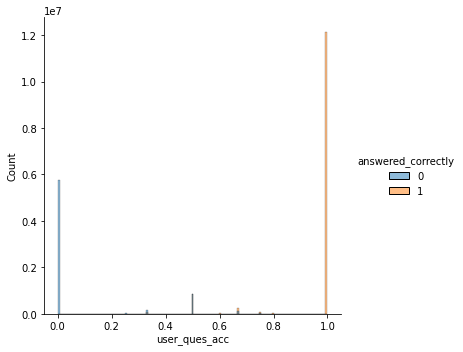

CPU times: user 5.61 s, sys: 1.28 s, total: 6.88 s
Wall time: 6.9 s


In [54]:
%%time
# Plot the distribution of values in column user_ques_acc

sns.displot(data=df_train, x='user_ques_acc', hue='answered_correctly')
plt.show()

In [24]:
%%time
# Concat the user_ques_acc to the df_validate

df_validate = df_validate.merge(user_ques_accuracy, how='left', 
                                left_on = ['user_id', 'content_id'], 
                                right_on = ['user_id', 'content_id'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 4.89 s, sys: 1.57 s, total: 6.46 s
Wall time: 6.5 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2193284
dtype: int64

In [36]:
# What percent of the values in column user_ques-acc are missing? 
print(f"{round((2193284*100/df_validate.shape[0]),2)}% of the values in column user_ques_acc is missing")

86.32% of the values in column user_ques_acc is missing


In [38]:
%%time
# Concat the user_ques_acc to the df_test

df_test = df_test.merge(user_ques_accuracy, how='left', 
                        left_on = ['user_id', 'content_id'], 
                        right_on = ['user_id', 'content_id'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 4.89 s, sys: 1.66 s, total: 6.55 s
Wall time: 6.59 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2312506
dtype: int64

In [66]:
# What percent of the values in the column user_ques_acc are missing?
print(f"{round((2312506*100/df_test.shape[0]),2)}% of the values in column user_ques_acc is missing")

87.44% of the values in column user_ques_acc is missing


**Takeaways**: About 87% of the questions in the validate and test dataset are new to the users. 

### Add new features - user_bundle_accuracy

In [56]:
%%time
# Compute the user_bundle_accuracy

user_bundle_accuracy = explore.compute_user_bundle_acc(df_train)
user_bundle_accuracy.head(2)

CPU times: user 5.76 s, sys: 2.13 s, total: 7.89 s
Wall time: 8.06 s


,user_id,bundle_id,user_bundle_acc
0,24600,175,1.0
1,24600,1278,1.0


In [58]:
%%time
# Concat the user_bundle_acc to the df_train

df_train = df_train.merge(user_bundle_accuracy, how='left', 
                          left_on = ['user_id', 'bundle_id'], 
                          right_on = ['user_id', 'bundle_id'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20554519 entries, 0 to 20554518
Data columns (total 14 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  bool   
 6   question_id                     int16  
 7   bundle_id                       int16  
 8   correct_answer                  int8   
 9   part                            int8   
 10  tags                            object 
 11  tag_count                       int8   
 12  user_ques_acc                   float16
 13  user_bundle_acc                 float16
dtypes: bool(1), float16(2), float32(1), int16(4), int32(1), int8(4), object(1)
memory usage: 803.7+ MB
CPU times: user 7.61 s, sys: 2.79 s, total: 10.4 s
Wall time:

In [65]:
%%time
# Concat the user_bundle_acc to the df_validate

df_validate = df_validate.merge(user_bundle_accuracy, how='left', 
                                left_on = ['user_id', 'bundle_id'], 
                                right_on = ['user_id', 'bundle_id'])

# Check the missing values
df_validate.isnull().sum(axis=0)

CPU times: user 4.05 s, sys: 1.52 s, total: 5.57 s
Wall time: 5.74 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2193284
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2147909
dtype: int64

In [67]:
# What percent of the values in column user_bundle_acc are missing? 
print(f"{round((2147909*100/df_validate.shape[0]),2)}% of the values in column user_bundle_acc is missing")

84.53% of the values in column user_bundle_acc is missing


In [69]:
%%time
# Concat the user_bundle_acc to the df_test

df_test = df_test.merge(user_bundle_accuracy, how='left', 
                        left_on = ['user_id', 'bundle_id'], 
                        right_on = ['user_id', 'bundle_id'])

# Check the missing values
df_test.isnull().sum(axis=0)

CPU times: user 4.17 s, sys: 1.24 s, total: 5.41 s
Wall time: 5.46 s


user_id                                 0
content_id                              0
task_container_id                       0
answered_correctly                      0
prior_question_elapsed_time             0
prior_question_had_explanation          0
user_ques_acc                     2312506
question_id                             0
bundle_id                               0
correct_answer                          0
part                                    0
tags                                    0
tag_count                               0
user_bundle_acc                   2312095
dtype: int64

In [70]:
# What percent of the values in column user_bundle_acc are missing? 
print(f"{round((2312095*100/df_test.shape[0]),2)}% of the values in column user_bundle_acc is missing")

87.43% of the values in column user_bundle_acc is missing


**Takeaways**: About 86% of the questions in the validate and test dataset are new to the users. 

In [71]:
# Release memory
print("Memory usage before running garbage collector: ", psutil.virtual_memory().percent)
gc.collect
print("Memory usage after: ", psutil.virtual_memory().percent)

Memory usage before running garbage collector:  58.7
Memory usage after:  58.7
